In [1]:
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic,CartesianRepresentation,CartesianDifferential
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette('Set1')
from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
import matplotlib as mpl 
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.titlesize'] = 14

splat.initializeStandards(all=True)

%matplotlib inline

Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database






In [2]:
#get evolutionary models
baraffe=popsims.make_systems(model_name='baraffe2003', recompute=False, nsample=1e5)
romandrfs=popsims.make_systems(model_name='roman2020', range=[0.01, 0.2, 10, 13.5 ],
                             recompute=False, nsample=1e5)

In [3]:
popsims.POLYNOMIALS.keys()

dict_keys(['WFIRST_WFIJ', 'WFIRST_WFIY', 'WFIRST_WFIZ', 'WFIRST_WFIH', 'WFIRST_WFIF', 'WFIRST_WFIR', 'EUCLID_J', 'EUCLID_H', 'EUCLID_Y', 'LSST_Y', 'LSST_Z', 'LSST_R', 'NIRCAM_F115W', 'NIRCAM_F140M', 'NIRCAM_F150W', 'NIRCAM_F200W', '2MASS_K', 'WISE_W1'])

In [4]:
H=350
FOV={'wfirst':2000.*(u.deg**2), 'euclid':20*(u.deg**2) , 'lsst':3.5*(u.deg**2) ,
     'jswt':1*(u.deg**2), 'spherex': 1*u.deg**2}

#make magnitude cuts
CUTS={'wfirst':{'WFIRST_WFIJ': [1,28.], 'WFIRST_WFIH':[1,28.]},
     'lsst':{'LSST_Z':[1, 26.1],'LSST_Y':[1, 24.]},
     'euclid':{'EUCLID_J': [1, 27.], 'EUCLID_H': [1,27.]}}

WIDE_CUTS={'wfirst':{'WFIRST_WFIJ': [1,24.], 'WFIRST_WFIH':[1,24.]},
     'lsst':{'LSST_Z':[1, 24.1],'LSST_Y':[1, 24.]},
     'euclid':{'EUCLID_J': [1, 24.], 'EUCLID_H': [1,24.]}}

POINTS={'wfirst':SkyCoord(l=-30.0*u.deg, b=-30*u.deg, frame='galactic'),
        'euclid':SkyCoord(l=24.6*u.deg, b=-82.0*u.deg , frame='galactic'),
        'lsst':SkyCoord(l=224.07*u.deg, b=-54.47*u.deg, frame='galactic'),
        'jswt':SkyCoord(l=224.07*u.deg, b=-54.47*u.deg, frame='galactic'),
        'spherex':SkyCoord(l=224.07*u.deg, b=-54.47*u.deg, frame='galactic')}

In [5]:
#standards
((133*u.arcmin)**2).to(u.degree**2)

<Quantity 4.91361111 deg2>

In [6]:
def make_cuts(df, survey, cut_dict):
    dcts=cut_dict[survey]
    return df[np.logical_and.reduce([df[k]< dcts[k][1] for k in dcts.keys()])]

def get_average_distance_limits(p, survey, cut_dict):
    p.mag_limits=cut_dict[survey]
    return dict(pd.DataFrame(p.distance_limits).applymap(lambda x: x[1]).median(axis=1))

In [7]:
#

In [8]:
#dff= popsims.create_population(baraffe,s, kind='disk')

In [9]:
def get_numbers(fov0, points, cuts):
    NCOUNTS={}
    for k in cuts.keys():
        s=points[k]
        fov=fov0[k]
        dff= popsims.create_population(baraffe,s, kind='disk')
        sd_dff= popsims.create_population(romandrfs, s, kind='halo')
        
        dff=dff[dff.spt>=15.].reset_index(drop=True)
        sd_dff=sd_dff[sd_dff.spt>=15.].reset_index(drop=True)

        df_cut= make_cuts(dff, k, cuts)
        sd_cut=make_cuts(sd_dff, k, cuts)

        nxbr_counts=[]
        p=popsims.Pointing(coord=s)
        dct= get_average_distance_limits(p, k, cuts)

        model_name='baraffe2003'
        lf=pd.read_pickle('/Users/caganze/research/wisps/db/lf_scales.pkl')
        #scale lf
        scale=lf[model_name]
        sn=len(df_cut[np.logical_and(df_cut.teff>=450, df_cut.teff<=1950)])
        sca_sdf=len(df_cut)/len(sd_cut)

        for spt in np.arange(17,40):

            df_select= df_cut[np.logical_and(df_cut.spt>=spt, df_cut.spt<spt+0.99)]
            sdf_select= sd_cut[np.logical_and(sd_cut.spt>=spt, sd_cut.spt<spt+0.99)]

            vol=popsims.volume_calc(s.l.radian, s.b.radian,
                                       1., dct[spt], H)*(fov.to(u.radian**2))
            nbrs=len(df_select)
            sd_nbrs= len(sdf_select)

            cnbrs=nbrs*vol*(scale[-1]/sn)/(fov.to(u.deg**2))
            sd_cnbrs=sd_nbrs*vol*(scale[-1]/sn)*sca_sdf/(fov.to(u.deg**2))


            nxbr_counts.append([cnbrs, 0.0051*sd_cnbrs])
            #print (sd_cnbrs/cnbrs)

        NCOUNTS[k]=nxbr_counts#, df]
    return NCOUNTS
        



In [10]:
titles={'wfirst': 'Roman Telescope', 'euclid': 'Euclid', 'lsst':'Rubin Observatory '}

In [11]:
NCOUNTS=get_numbers(FOV, POINTS, CUTS)

In [12]:
NCOUNTS_WIDE=get_numbers(FOV, POINTS,WIDE_CUTS)

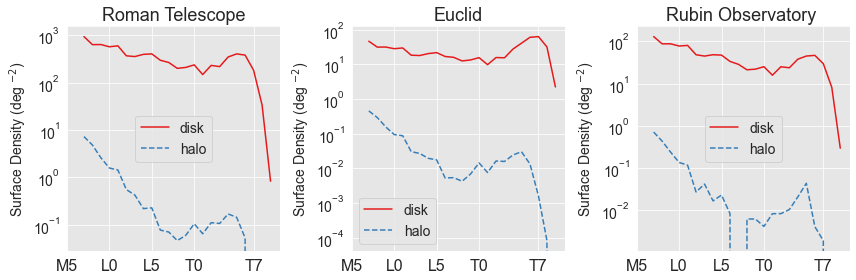

In [13]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
for k, a in zip(FOV.keys(), ax):
    arr=np.vstack(np.array([[x.value for x in y] for y in NCOUNTS[k]]))
    a.semilogy( np.arange(17,40), arr[:,0], label='disk')
    a.semilogy( np.arange(17,40), arr[:,1], label='halo', linestyle='--')
    a.set_ylabel(r'Surface Density (deg $^{-2}$)')
    a.set_xticks([15, 20, 25, 30, 37])
    a.legend()
    a.set_xticklabels(['M5', 'L0', 'L5', 'T0', 'T7'], fontsize=16)
    a.set_title(titles[k], fontsize=18)

plt.tight_layout()
plt.savefig(popsims.FIGURES+'/number_counts.jpeg', rasterized=True)

In [14]:
WIDE_FOVS=dict(zip([x for x in NCOUNTS_WIDE.keys()],\
               [2000, 15000, 18000]))

In [15]:
WIDE_FOVS.keys()

dict_keys(['wfirst', 'lsst', 'euclid'])

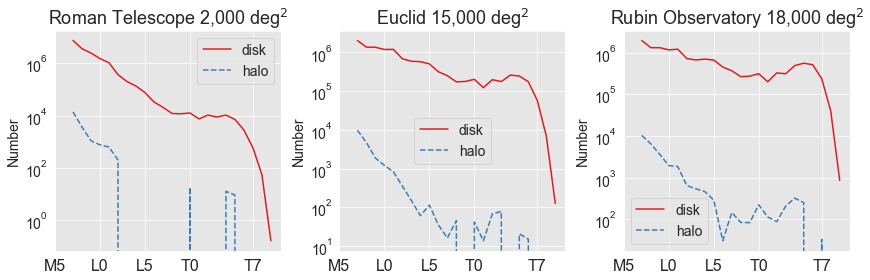

In [16]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
for k, a in zip(FOV.keys(), ax):
    arr=np.vstack(np.array([[x.value*WIDE_FOVS[k] for x in y] \
                            for y in NCOUNTS_WIDE[k]]))
    a.semilogy( np.arange(17,40), arr[:,0], label='disk')
    a.semilogy( np.arange(17,40), arr[:,1], label='halo', linestyle='--')
    a.set_ylabel(r'Number')
    a.set_xticks([15, 20, 25, 30, 37])
    a.legend()
    a.set_xticklabels(['M5', 'L0', 'L5', 'T0', 'T7'], fontsize=16)

ax[0].set_title(r'Roman Telescope 2,000 deg$^2$', fontsize=18)
ax[1].set_title(r'Euclid 15,000 deg$^2$', fontsize=18)
ax[-1].set_title('Rubin Observatory 18,000 deg$^2$', fontsize=18)

plt.tight_layout()
plt.savefig(popsims.FIGURES+'/number_counts_wide.jpeg', rasterized=True)

In [17]:

grism_cuts={
      'GRS':{'WFIRST_WFIJ':[1, 20.8]},
    'PRS':{'WFIRST_WFIJ':[1, 23.5]},
    'JSWT':{'NIRCAM_F200W':[1, 27.2]},
    'JSWTJ':{'NIRCAM_F115W':[1, 27.2]},
    'EUCLID':{'EUCLID_J':[1, 21.]},
    'SPHEREX': {'WISE_W1': [1, 22.]}}

fov_spc=dict(zip([x for x in grism_cuts.keys()], [1*(u.deg**2) for x in grism_cuts.keys()]))

points_sp={'GRS':POINTS['wfirst'],
           'PRS': POINTS['wfirst'],
           'JSWT': POINTS['jswt'],
           'JSWTJ': POINTS['jswt'],
           'EUCLID':  POINTS['euclid'],
           'SPHEREX':POINTS['spherex']}
           


In [18]:
NCOUNTS2=get_numbers(fov_spc, points_sp, grism_cuts)

In [19]:
len(fov_spc)

6

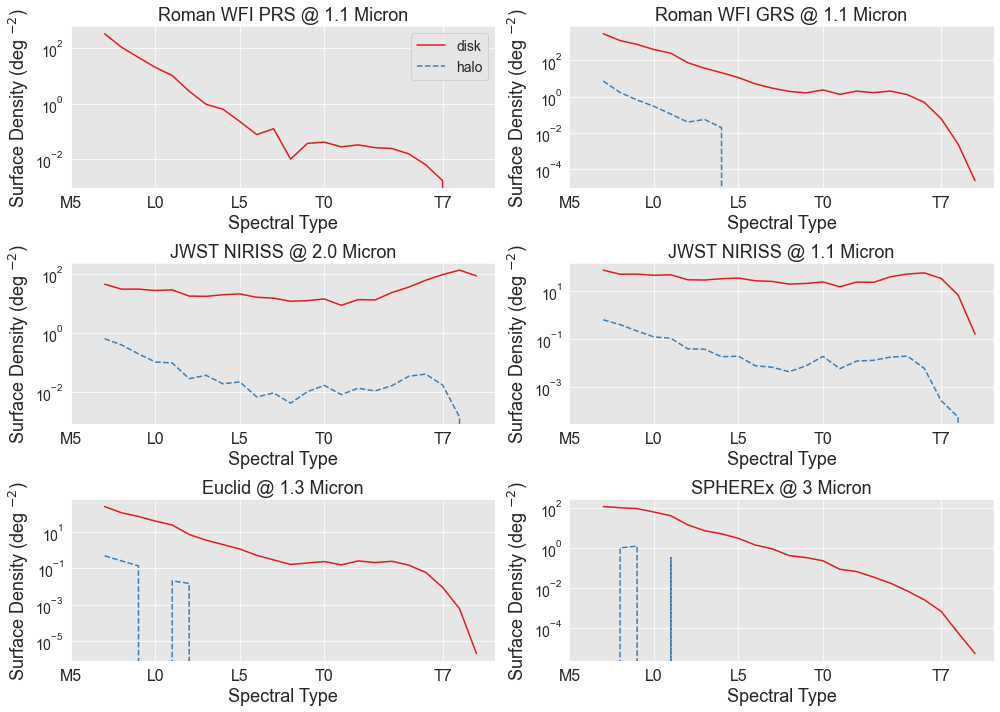

In [20]:
fig, ax=plt.subplots(ncols=2, nrows=3, figsize=(14, 10))
for k, a in zip(fov_spc.keys(), np.concatenate(ax)):
    arr=np.vstack(np.array([[x.value for x in y] for y in NCOUNTS2[k]]))
    a.semilogy( np.arange(17,40), arr[:,0], label='disk')
    a.semilogy( np.arange(17,40), arr[:,1], label='halo', linestyle='--')
    a.set_ylabel(r'Surface Density (deg $^{-2}$)', fontsize=18)
    a.set_xlabel(r'Spectral Type', fontsize=18)
    a.set_xticks([15, 20, 25, 30, 37])
    a.set_xticklabels(['M5', 'L0', 'L5', 'T0', 'T7'], fontsize=16)
    #a.set_title(titles[k], fontsize=18)
ax[0][0].set_title('Roman WFI PRS @ 1.1 Micron', fontsize=18)
ax[0][1].set_title('Roman WFI GRS @ 1.1 Micron', fontsize=18)

ax[1][0].set_title('JWST NIRISS @ 2.0 Micron', fontsize=18)
ax[1][1].set_title('JWST NIRISS @ 1.1 Micron', fontsize=18)

ax[2][0].set_title('Euclid @ 1.3 Micron', fontsize=18)
ax[2][1].set_title('SPHEREx @ 3 Micron', fontsize=18)
plt.tight_layout()

ax[0][0].legend()
#ax[0].set_xlim(1.5, 3.2 )
#ax[1].set_xlim(1.5, 4.)
plt.tight_layout()
plt.savefig(popsims.FIGURES+'/all_spectroscopic_counts.jpeg', dpi=600)